In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gstools import Gaussian,CovModel
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging


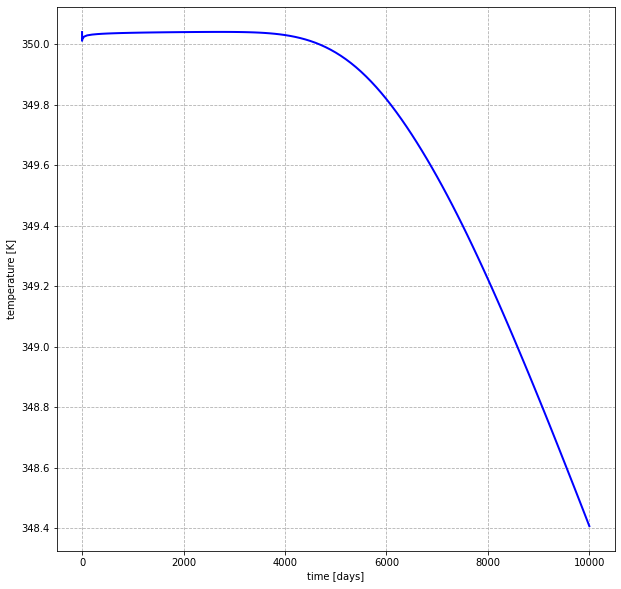

In [2]:
nograv = pd.read_excel(open('./RealBase/base_resolution_he.xlsx', 'rb'), sheet_name='Sheet1')

fig, ax = plt.subplots(1, 1,figsize=(10, 10))
axx = fig.axes
time_arr = nograv['time'].to_numpy()
string = 'PRD : temperature (K)'
axx[0].plot(nograv['time'], nograv[string], linewidth=2, color='b', label='without grav')
axx[0].grid(which='both',linestyle='--')
axx[0].set_xlabel('time [days]')
axx[0].set_ylabel('temperature [K]')
plt.show()

In [ ]:
# predefined reservoir size: 60*40*1
nx = 60
ny = 40
nz = 1
# read-in permeability and porosity from files
kx = np.genfromtxt('permx_2D.txt', skip_header=True, skip_footer=True).flatten()
ky = np.genfromtxt('permy_2D.txt', skip_header=True, skip_footer=True).flatten()
kz = np.genfromtxt('permz_2D.txt', skip_header=True, skip_footer=True).flatten()
poro = np.genfromtxt('poro_2D.txt', skip_header=True, skip_footer=True).flatten()
# self.kx[self.kx > 5] = 3000
# self.kx[self.kx <= 5] = 5
# self.ky = self.kx
# self.kz = self.kx / 10
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(kx.reshape((40, 60)), origin='lower')
caxes.set_clim(0, max(kx))
plt.xlabel("X(m)")
plt.ylabel("Y(m)")
cbar = plt.colorbar(caxes, fraction=0.036, pad=0.04)
cbar.set_label('mD')
plt.savefig('_permx.pdf', bbox_inches='tight')
plt.clf()
axes = figure.add_subplot(111)
caxes = axes.matshow(poro.reshape((40, 60)), origin='lower')
caxes.set_clim(0, max(poro))
plt.xlabel("X(m)")
plt.ylabel("Y(m)")
cbar = plt.colorbar(caxes, fraction=0.036, pad=0.04)
plt.scatter([15, 48], [20, 20], c=[0, 100], s=100, cmap='rainbow')  # plot the well locations
plt.savefig('_poro.pdf', bbox_inches='tight')
plt.show()
# Kriging interpolation--------------------------------
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
Kriging_switch = 0  # 0 --- ordinary kriging; 1 --- universal kriging
np.random.seed(1234)
n_sample = 40  # set 1000 samples to test if the code is correct
data_idx_x = np.random.randint(nx, size=n_sample)
data_idx_y = np.random.randint(ny, size=n_sample)
# data_poro = 0.225 * (1 + 0.15 * np.random.randn(n_sample))  # generate Gaussian poro of N~(0.225，0.15)
poro_temp = poro.reshape((ny, nx))
data_poro = np.zeros(n_sample)
for ii in range(n_sample):
    data_poro[ii] = poro_temp[data_idx_y[ii]][data_idx_x[ii]]
data = np.zeros((n_sample, 3))
data[:, 0] = data_idx_x
data[:, 1] = data_idx_y
data[:, 2] = data_poro
gridx = np.arange(0, nx, 1)
gridy = np.arange(0, ny, 1)
# gridx = np.mgrid[0:99:100j]
# gridy = np.mgrid[0:99:100j]
data = data.astype(float)
data = np.array(data)
gridx = gridx.astype(float)
gridy = gridy.astype(float)
if Kriging_switch == 0:
    # params = {'sill': 25, 'range': 20, 'nugget': 2}
    OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='gaussian',
                         verbose=True, weight=False, enable_plotting=False, enable_statistics=True, nlags=15)
    z, ss = OK.execute('grid', gridx, gridy)
elif Kriging_switch == 1:
    UK = UniversalKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='gaussian',
                          verbose=True, enable_plotting=False, nlags=15)
    z, ss = UK.execute('grid', gridx, gridy)
z[z < 0.1] = 0.01
z[z > 0.4] = 0.4
plt.hist(z.flatten(), 25, density=True, facecolor='silver')
plt.show()
# plt.imshow(z)
plt.matshow(z, origin='lower', cmap='plasma')
plt.show()
# smoothen the sample point
for ii, sample in enumerate(data):
    neighbors = []
    try:
        if int(sample[0] - 1) == -1:
            pass
        else:
            neighbors.append(z[int(sample[1]), int(sample[0] - 1)])
    except Exception as e:
        print(str(e))
    try:
        neighbors.append(z[int(sample[1]), int(sample[0] + 1)])
    except Exception as e:
        print(str(e))
    try:
        if int(sample[1] - 1) == -1:
            pass
        else:
            neighbors.append(z[int(sample[1] - 1), int(sample[0])])
    except Exception as e:
        print(str(e))
    try:
        neighbors.append(z[int(sample[1] + 1), int(sample[0])])
    except Exception as e:
        print(str(e))
    z[int(sample[1]), int(sample[0])] = np.average(neighbors)
# plt.hist(z.flatten(), 25, density=True, facecolor='silver')
# plt.show()
# # plt.imshow(z)
# plt.matshow(z, origin='lower', cmap='plasma')
# plt.show()
# normal poro, lognormal perm--------------------------
# self.poro = np.array(z.flatten())
# self.kx = 10000000000 ** self.poro
# self.ky = 10000000000 ** self.poro
# self.kz = 10000000000 ** self.poro / 10

In [58]:
def apply_kriging(nx, ny, n_sample, poro):

    Kriging_switch = 1  # 0 --- ordinary kriging; 1 --- universal kriging

    np.random.seed(1234)
    # n_sample = 40  # set 1000 samples to test if the code is correct
    data_idx_x = np.random.randint(nx, size=n_sample)
    data_idx_y = np.random.randint(ny, size=n_sample)

    # data_poro = 0.225 * (1 + 0.15 * np.random.randn(n_sample))  # generate Gaussian poro of N~(0.225，0.15)
    # poro_temp = poro.reshape((ny, nx))
    data_poro = np.zeros(n_sample)
    for ii in range(n_sample):
        # data_poro[ii] = poro_temp[data_idx_y[ii]][data_idx_x[ii]]
        data_poro[ii] = poro[ii]
        
    data = np.zeros((n_sample, 3))
    data[:, 0] = data_idx_x
    data[:, 1] = data_idx_y
    data[:, 2] = data_poro

    gridx = np.arange(0, nx, 1)
    gridy = np.arange(0, ny, 1)
    # gridx = np.mgrid[0:99:100j]
    # gridy = np.mgrid[0:99:100j]
    data = data.astype(float)
    data = np.array(data)
    gridx = gridx.astype(float)
    gridy = gridy.astype(float)
    cov_model = Gaussian(dim=2, len_scale=10,anis=5.8,angles=-0.5,var=2.5,nugget=0.7)
    if Kriging_switch == 0:
        # params = {'sill': 25, 'range': 20, 'nugget': 2}
        # OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='gaussian',
        #                      verbose=True, weight=False, enable_plotting=False, enable_statistics=True, nlags=15, cov_model=cov_model)
        OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], cov_model)

        z, ss = OK.execute('grid', gridx, gridy)
    elif Kriging_switch == 1:
        UK = UniversalKriging(data[:, 0], data[:, 1], data[:, 2], cov_model)
        z, ss = UK.execute('grid', gridx, gridy)

    z[z < 0.1] = 0.01
    z[z > 0.4] = 0.4

    # plt.hist(z.flatten(), 25, density=True, facecolor='silver')
    # plt.show()
    # plt.imshow(z)
    # # plt.matshow(z, origin='lower', cmap='plasma')
    # plt.show()

    #smoothen the sample point
    for ii, sample in enumerate(data):
        neighbors = []
        try:
            if int(sample[0] - 1) == -1:
                pass
            else:
                neighbors.append(z[int(sample[1]), int(sample[0] - 1)])
        except Exception as e:
            print(str(e))

        try:
            neighbors.append(z[int(sample[1]), int(sample[0] + 1)])
        except Exception as e:
            print(str(e))

        try:
            if int(sample[1] - 1) == -1:
                pass
            else:
                neighbors.append(z[int(sample[1] - 1), int(sample[0])])
        except Exception as e:
            print(str(e))

            try:
                neighbors.append(z[int(sample[1] + 1), int(sample[0])])
            except Exception as e:
                print(str(e))

            z[int(sample[1]), int(sample[0])] = np.average(neighbors)
    
    plt.hist(z.flatten(), 25, density=True, facecolor='silver')
    plt.show()
    plt.imshow(z)
    # plt.matshow(z, origin='lower', cmap='plasma')
    plt.show()

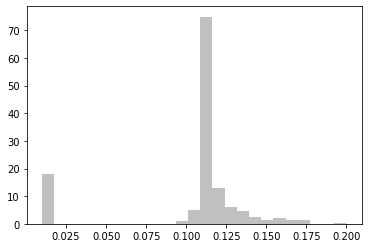

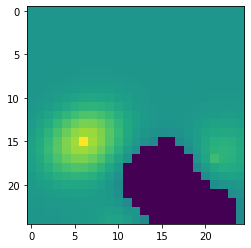

In [26]:
apply_kriging(25,25,5,np.array([0.01,0.05,0.2,0.14,0.11,0.3,0.35]))

In [35]:
points = np.array([[51.98991813, 4.23917247, 0.45],[51.97680574, 4.28231229, 0.33],[52.02113081, 4.42210836, 0.24],[52.00795104, 4.42027563,0.16],[52.02368551, 4.23784102,0.01],[52.01534736, 4.2253489,0.16],[52.00643923, 4.26965255,0.14]])

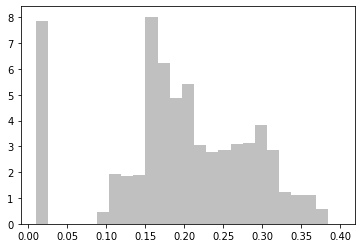

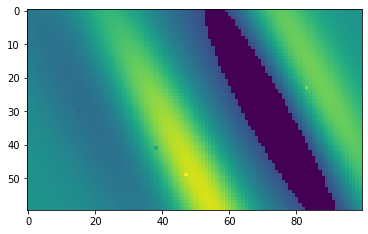

In [61]:
apply_kriging(100,60,len(points[:,2]),points[:,2])

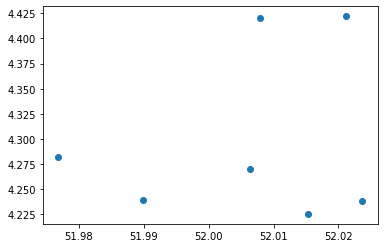

In [73]:
plt.scatter(points[:,0],points[:,1])

In [77]:
min_p = (min(points[:,0]),min(points[:,1]))
max_p = (max(points[:,0]),max(points[:,1]))
print(min_p)
print(max_p)

(51.97680574, 4.2253489)
(52.02368551, 4.42210836)
